# Charting Changes in US Indexes 
Bryant Crocker 

In the past few months US markets have been extremely weak.  In order to get a better idea of these changes I threw together some quick charts displaying the changes in these indexes.

In [2]:
# import necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import fix_yahoo_finance as yf
#this makes fix yahoo finance work
yf.pdr_override()
%matplotlib inline 
#this is needed to import ffn
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn

Use fix-yahoo-finance to pull in data from SP500, Down Jones Industrial, Nasdaq and Russel 2000 

In [4]:
# Create a list with the tickers that we want to get.
tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT']
# Get OHLC data for these tickers from 2017 on
exchanges = yf.download(tickers, start="2017-01-01")
# select just the adjusted close column
close = exchanges['Adj Close']

[*********************100%***********************]  4 of 4 downloaded


I start by comparing returns in 2017 vs 2018.  It appears that returns are a bit more volatile in 2018 than 2017.

/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


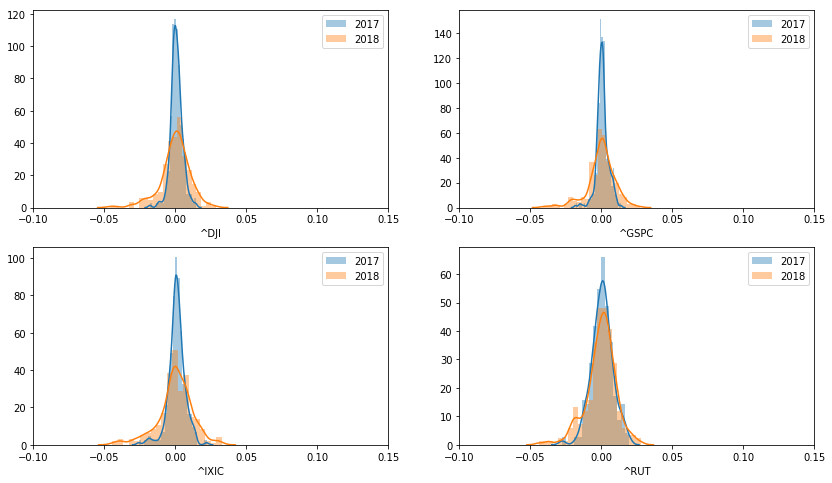

In [7]:
close_2018 = close[close.index >= pd.to_datetime('2018-01-01')]
close_2017 = close[close.index < pd.to_datetime('2018-01-01')]
fig, ax = plt.subplots(2,2, figsize = (14, 8))
ax = ax.ravel()
j = 0
for i in close.columns:
    sns.distplot(close_2017[i].pct_change().dropna(), ax = ax[j], label = '2017')
    sns.distplot(close_2018[i].pct_change().dropna(), ax = ax[j], label = '2018')
    ax[j].legend()
    ax[j].set_xlim(-0.1, 0.15)
    j += 1

I was interested in what the posterior distribution of volatility looked like for the two different years.  I wanted to infer if there had been a signifigant change in the sigma parameter.  To get at this question I sue the bayesian boostrap, which using boostrapping and a non-informative prior to establish a posterior distribution of a given parameter.

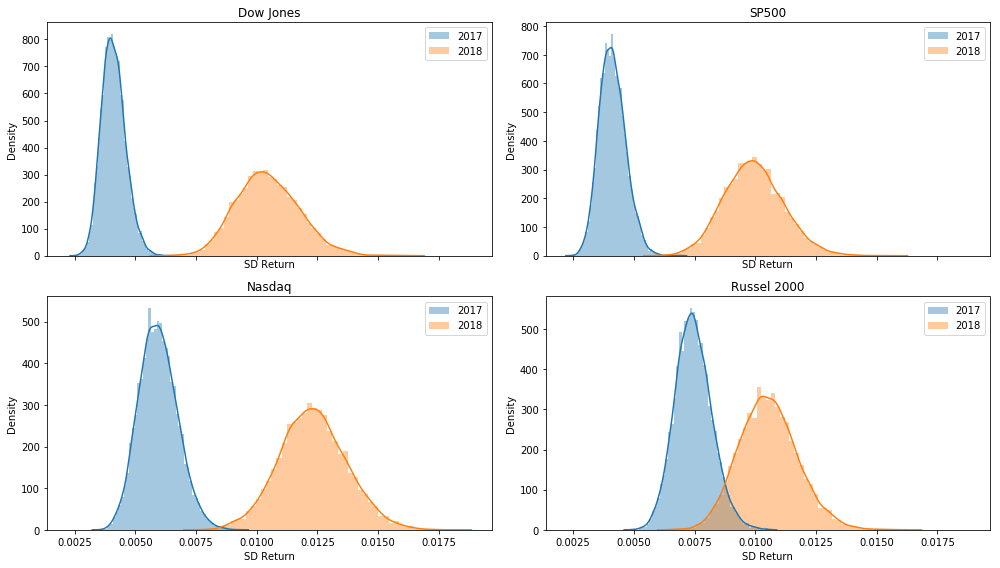

In [8]:
from bayesian_bootstrap.bootstrap import bayesian_bootstrap
fig, ax = plt.subplots(2, 2, figsize = (14, 8), sharex = True)
ax = ax.ravel()
j = 0
names = ['Dow Jones', 'SP500', 'Nasdaq', 'Russel 2000']
for i, k  in zip(close.columns, names):
    X = close_2017[i].pct_change().dropna()
    posterior_samples_2017 = bayesian_bootstrap(X, np.std, 10000, 100)
    sns.distplot(posterior_samples_2017, ax = ax[j], label = '2017')
    X = close_2018[i].pct_change().dropna()
    posterior_samples_2018 = bayesian_bootstrap(X, np.std, 10000, 100)
    sns.distplot(posterior_samples_2018, ax = ax[j], label = '2018')
    ax[j].set_title(k)
    ax[j].set_xlabel('SD Return')
    ax[j].set_ylabel('Density')
    ax[j].legend()
    j += 1
plt.tight_layout()
plt.savefig('plots/volatility.png')

It's clear that volatility is signifigantly higher in 2018 than in 2017.  We are least certain of this with Russel 2000.  Let's look at what the drawdowns have looked like for the past 2 years.

/anaconda3/envs/Main/lib/python3.6/site-packages/ffn/core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


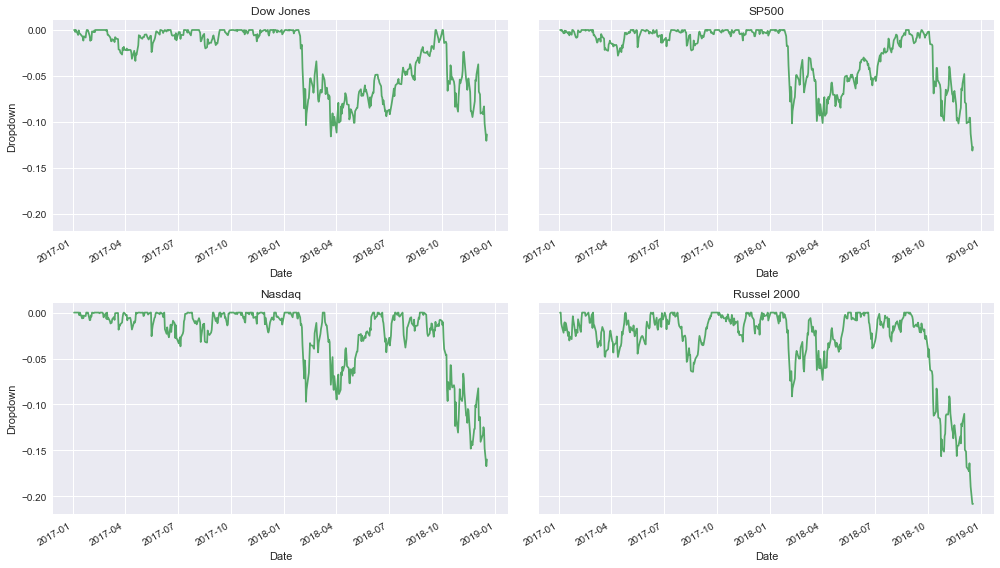

In [9]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,2, figsize = (14, 8), sharey = True)
ax = ax.ravel()
j = 0
names = ['Dow Jones', 'SP500', 'Nasdaq', 'Russel 2000']
for i, k  in zip(close.columns, names):
    stats = close[i].calc_stats()
    stats.prices.to_drawdown_series().plot(ax = ax[j], color = 'C1')
    ax[j].set_title(k)
    ax[j].set_ylabel('Dropdown')
    j += 1
plt.tight_layout()
plt.savefig('plots/dropdowns.png')

We can see that since March of 2018 there have been frequent, large drops in us indexes.  This is a problematic sign and gives the sign that good market conditions might be ending.